In [1]:
%load_ext autoreload
%autoreload 2
    
import numpy as np
import pandas as pd

from random import randint

import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")

from sklearn.model_selection import train_test_split

from skimage.transform import resize
import torch
from torch import nn
from torch.nn import functional as F
from torchvision import models
import torchvision

from pathlib import Path
from torch.nn import functional as F

from tqdm import tqdm_notebook, tqdm

In [2]:
from image_processing import upsample, downsample
from data import prepare_data, test_images_path,load_images_as_arrays, TGSSaltDataset
import os
from visualisation import (plot_coverage_and_coverage_class, 
                           scatter_coverage_and_coverage_class,
                           plot_depth_distributions,
                           plot_predictions,
                           plot_images)
from model import model_path, save_checkpoint, update_state
from metrics import iou_metric_batch, my_iou_metric, my_iou_metric_2
from toolz import compose
from data import run_length_encode, rle_encode
import datetime
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch

from torch.utils import data
from shake_shake import Network, UNet
from training import train, test
from collections import defaultdict
import logging
import random
from utils import create_optimizer, tboard_log_path
from tensorboardX import SummaryWriter
import uuid
import itertools as it
from operator import itemgetter
import shutil

In [3]:
now = datetime.datetime.now()

In [4]:
img_size_target = 112
batch_size =      64
learning_rate =   0.07
epochs =          50
num_workers =     0
seed =            42
num_cycles =      6   # Using Cosine Annealing with warm restarts, the number of times to oscillate
notebook_id =     f"{now:%d%b%Y}_{uuid.uuid4()}" 
config={
    "run_config": { "arch": "shake_shake",
           "base_channels": 64,
           "depth": 26,
           "shake_forward": True,
           "shake_backward": True,
           "shake_image": True,
           "input_shape": (1, 1, img_size_target, img_size_target)
},
"optim_config": {
    "optimizer": "sgd",
    "base_lr": learning_rate,
    "momentum": 0.9,
    "weight_decay": 1e-4,
    "nesterov": True,
    "epochs": epochs,
    "scheduler": "cosine",
    "lr_min": 0,
}
} 

In [5]:
logging.basicConfig(level=logging.INFO)
torch.backends.cudnn.benchmark = True
logger = logging.getLogger(__name__)
logger.info(f"Started {now}")
tboard_log = os.path.join(tboard_log_path(), f"log_{notebook_id}")
logger.info(f"Writing TensorBoard logs to {tboard_log}")
summary_writer = SummaryWriter(log_dir=tboard_log)

INFO:__main__:Started 2018-09-25 16:27:46.841392
INFO:__main__:Writing TensorBoard logs to /mnt/models/logs/pytorch_unet_shake_shake/a53bc1685d575e0add011df986867b7f3b8adaf2/log_25Sep2018_23ec6a5c-a868-4d02-8aa1-70b1570fd38b


In [6]:
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [7]:
model=UNet(config['run_config'])

In [8]:
n_params = sum([param.view(-1).size()[0] for param in model.parameters()])
logger.info('n_params: {}'.format(n_params))

INFO:__main__:n_params: 34430849


In [9]:
device = torch.device("cuda:0")

In [10]:
model = nn.DataParallel(model)

In [11]:
model.to(device)

DataParallel(
  (module): UNet(
    (conv): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (stage1): Sequential(
      (block1): BasicBlock(
        (residual_path1): ResidualPath(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (residual_path2): ResidualPath(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1

In [12]:
# Test to check network
x = torch.randn(16,1,img_size_target,img_size_target).cuda()
model.forward(x).shape

torch.Size([16, 1, 112, 112])

In [13]:
train_df, test_df = prepare_data()

100%|██████████| 4000/4000 [00:01<00:00, 2615.90it/s]


In [14]:
train_df.head()

,z,images,masks,coverage,coverage_class
id,,,,,
575d24d81d,843,"[[0.5254901960784314, 0.5137254901960784, 0.52...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.000000,0
a266a2a9df,794,"[[0.3411764705882353, 0.3764705882352941, 0.33...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.504950,6
75efad62c1,468,"[[0.5686274509803921, 0.4666666666666667, 0.32...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.993334,10
34e51dba6a,727,"[[0.5411764705882353, 0.4745098039215686, 0.39...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.149201,2
4875705fb0,797,"[[0.06666666666666667, 0.0784313725490196, 0.0...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.042839,1


/opt/conda/envs/py3.6/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


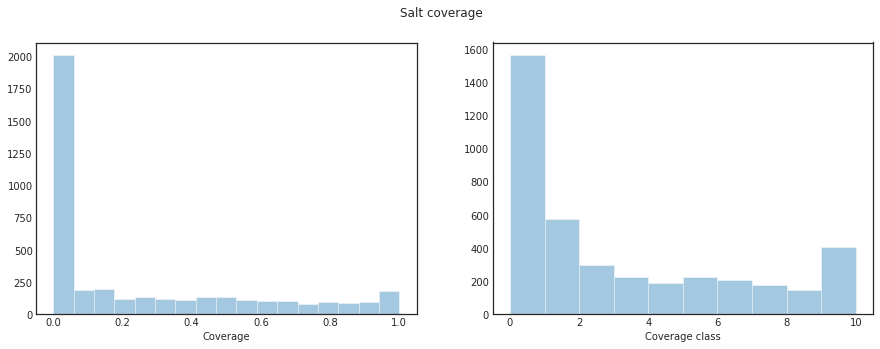

In [15]:
plot_coverage_and_coverage_class(train_df.coverage, train_df.coverage_class)

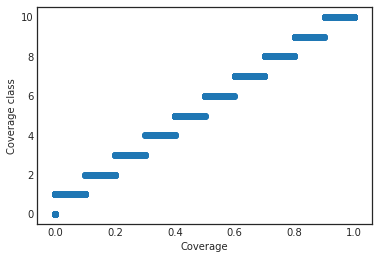

In [16]:
scatter_coverage_and_coverage_class(train_df.coverage, train_df.coverage_class)

/opt/conda/envs/py3.6/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


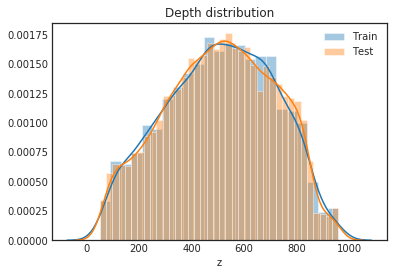

In [17]:
plot_depth_distributions(train_df.z, test_df.z)

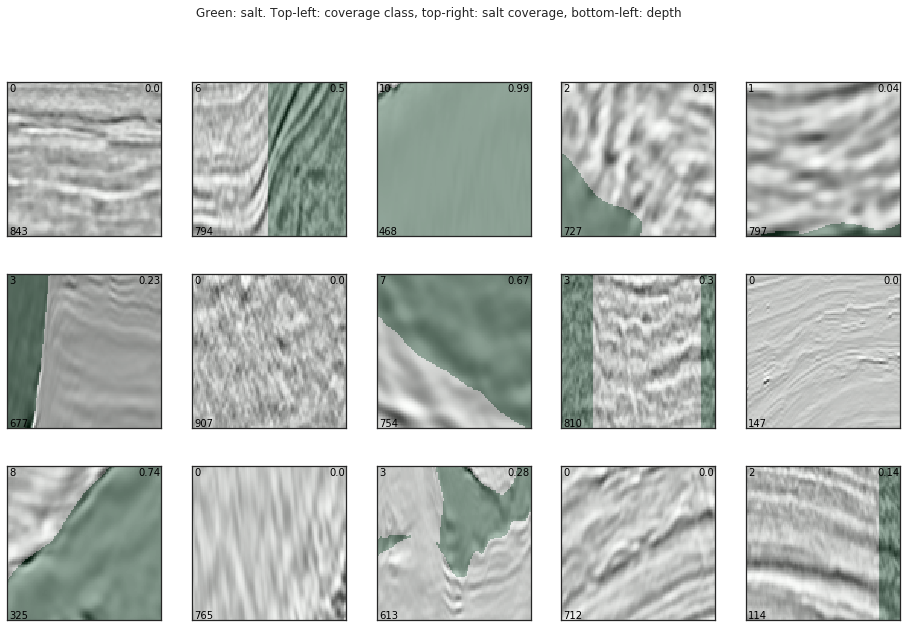

In [18]:
plot_images(train_df, max_images=15, grid_width=5, figsize=(16,10))

In [19]:
upsample_to = upsample(101, img_size_target)

In [20]:
ids_train, ids_valid, x_train, x_valid, y_train, y_valid, cov_train, cov_test, depth_train, depth_test = train_test_split(
    train_df.index.values,
    np.array(train_df.images.map(upsample_to).tolist()).reshape(-1, 1, img_size_target, img_size_target), 
    np.array(train_df.masks.map(upsample_to).tolist()).reshape(-1, 1, img_size_target, img_size_target), 
    train_df.coverage.values,
    train_df.z.values,
    test_size=0.2, 
    stratify=train_df.coverage_class, 
    random_state=seed)

In [21]:
# Augment data with flipped verisons
x_train = np.append(x_train, [np.fliplr(x) for x in x_train], axis=0)
y_train = np.append(y_train, [np.fliplr(x) for x in y_train], axis=0)

In [22]:
dataset = TGSSaltDataset(x_train, y_data=y_train)
dataset_val = TGSSaltDataset(x_valid, y_data=y_valid)

In [23]:
state = {
        'state_dict': None,
        'optimizer': None,
        'epoch': 0,
        'val_iou': 0,
        'best_val_iou': 0,
        'best_epoch': 0,
}

In [24]:
train_data_loader = data.DataLoader(dataset, 
                                    batch_size = batch_size, 
                                    shuffle = True,
                                    num_workers=num_workers,
                                    pin_memory=True,
                                    drop_last=True)
val_data_loader = data.DataLoader(dataset_val, 
                                   batch_size = batch_size,
                                   shuffle = False, 
                                   num_workers=num_workers,
                                   pin_memory=True,
                                   drop_last=False)

In [25]:
config["optim_config"]["steps_per_epoch"] = len(train_data_loader)

In [26]:
history = defaultdict(list)
loss_fn = torch.nn.BCELoss()

train.global_step = 0
global_counter = it.count()
cumulative_epochs_counter = it.count()
cycle_best_val_iou = {}
for cycle in range(num_cycles): # Cosine annealing with warm restarts
    optimizer, scheduler = create_optimizer(model.parameters(), config['optim_config'])
    for epoch in range(epochs):
        cum_epoch = next(cumulative_epochs_counter)
        train_metrics = train(cum_epoch, 
                              model, 
                              optimizer, 
                              scheduler, 
                              loss_fn, 
                              train_data_loader, 
                              config,
                              summary_writer=summary_writer,
                              global_counter=global_counter)

        val_metrics = test(cum_epoch, 
                           model, 
                           loss_fn, 
                           val_data_loader, 
                           summary_writer=summary_writer)

        state = update_state(state, 
                             cum_epoch, 
                             'val_iou', 
                             np.mean(val_metrics['iou']), 
                             model, 
                             optimizer)
        
        save_checkpoint(state, best_model_filename=f"model_{cycle}_best_state.pth")

        history['epoch'].append(cum_epoch)
        history['train_loss'].append(np.mean(train_metrics['loss']))
        history['val_loss'].append(np.mean(val_metrics['loss']))
        history['train_iou'].append(np.mean(train_metrics['iou']))
        history['val_iou'].append(np.mean(val_metrics['iou']))
    cycle_best_val_iou[cycle]=state['best_val_iou']

INFO:training:Train 0
INFO:training:Epoch: 0,Step: 0,Train: loss 9.079,  IoU 0.022
INFO:training:Epoch: 0,Step: 99,Train: loss 6.631,  IoU 0.248
INFO:training:Elapsed 49.82
INFO:training:Test 0
INFO:training:Epoch: 0,Val: loss 7.264, IoU 0.179 ** 
INFO:training:Elapsed 3.43
INFO:model:val_iou went from 0 to 0.17920673076923077 >:)
INFO:training:Train 1
INFO:training:Epoch: 1,Step: 0,Train: loss 6.141,  IoU 0.384
INFO:training:Epoch: 1,Step: 99,Train: loss 4.532,  IoU 0.350
INFO:training:Elapsed 47.91
INFO:training:Test 1
INFO:training:Epoch: 1,Val: loss 3.601, IoU 0.525 ** 
INFO:training:Elapsed 3.06
INFO:model:val_iou went from 0.17920673076923077 to 0.5252403846153846 >:)
INFO:training:Train 2
INFO:training:Epoch: 2,Step: 0,Train: loss 4.596,  IoU 0.398
INFO:training:Epoch: 2,Step: 99,Train: loss 3.922,  IoU 0.451
INFO:training:Elapsed 47.72
INFO:training:Test 2
INFO:training:Epoch: 2,Val: loss 4.803, IoU 0.389 ** 
INFO:training:Elapsed 3.12
INFO:training:Train 3
INFO:training:Epoch:

INFO:training:Train 27
INFO:training:Epoch: 27,Step: 0,Train: loss 0.182,  IoU 0.628
INFO:training:Epoch: 27,Step: 99,Train: loss 0.185,  IoU 0.628
INFO:training:Elapsed 48.06
INFO:training:Test 27
INFO:training:Epoch: 27,Val: loss 0.194, IoU 0.652 ** 
INFO:training:Elapsed 3.38
INFO:training:Train 28
INFO:training:Epoch: 28,Step: 0,Train: loss 0.207,  IoU 0.592
INFO:training:Epoch: 28,Step: 99,Train: loss 0.178,  IoU 0.644
INFO:training:Elapsed 48.03
INFO:training:Test 28
INFO:training:Epoch: 28,Val: loss 0.183, IoU 0.670 ** 
INFO:training:Elapsed 3.38
INFO:model:val_iou went from 0.6560096153846153 to 0.6704326923076922 >:)
INFO:training:Train 29
INFO:training:Epoch: 29,Step: 0,Train: loss 0.216,  IoU 0.661
INFO:training:Epoch: 29,Step: 99,Train: loss 0.178,  IoU 0.649
INFO:training:Elapsed 47.96
INFO:training:Test 29
INFO:training:Epoch: 29,Val: loss 0.183, IoU 0.650 ** 
INFO:training:Elapsed 3.43
INFO:training:Train 30
INFO:training:Epoch: 30,Step: 0,Train: loss 0.192,  IoU 0.594
I

INFO:training:Elapsed 48.15
INFO:training:Test 58
INFO:training:Epoch: 58,Val: loss 0.168, IoU 0.683 ** 
INFO:training:Elapsed 3.28
INFO:training:Train 59
INFO:training:Epoch: 59,Step: 0,Train: loss 0.171,  IoU 0.647
INFO:training:Epoch: 59,Step: 99,Train: loss 0.161,  IoU 0.663
INFO:training:Elapsed 48.03
INFO:training:Test 59
INFO:training:Epoch: 59,Val: loss 0.174, IoU 0.686 ** 
INFO:training:Elapsed 3.35
INFO:model:val_iou went from 0.6846153846153846 to 0.6859374999999999 >:)
INFO:training:Train 60
INFO:training:Epoch: 60,Step: 0,Train: loss 0.142,  IoU 0.625
INFO:training:Epoch: 60,Step: 99,Train: loss 0.157,  IoU 0.664
INFO:training:Elapsed 47.98
INFO:training:Test 60
INFO:training:Epoch: 60,Val: loss 0.173, IoU 0.682 ** 
INFO:training:Elapsed 3.36
INFO:training:Train 61
INFO:training:Epoch: 61,Step: 0,Train: loss 0.205,  IoU 0.664
INFO:training:Epoch: 61,Step: 99,Train: loss 0.155,  IoU 0.664
INFO:training:Elapsed 48.04
INFO:training:Test 61
INFO:training:Epoch: 61,Val: loss 0.

INFO:training:Epoch: 86,Step: 99,Train: loss 0.069,  IoU 0.756
INFO:training:Elapsed 47.85
INFO:training:Test 86
INFO:training:Epoch: 86,Val: loss 0.202, IoU 0.707 ** 
INFO:training:Elapsed 3.19
INFO:training:Train 87
INFO:training:Epoch: 87,Step: 0,Train: loss 0.087,  IoU 0.744
INFO:training:Epoch: 87,Step: 99,Train: loss 0.070,  IoU 0.756
INFO:training:Elapsed 47.81
INFO:training:Test 87
INFO:training:Epoch: 87,Val: loss 0.222, IoU 0.709 ** 
INFO:training:Elapsed 3.23
INFO:training:Train 88
INFO:training:Epoch: 88,Step: 0,Train: loss 0.060,  IoU 0.811
INFO:training:Epoch: 88,Step: 99,Train: loss 0.069,  IoU 0.762
INFO:training:Elapsed 47.66
INFO:training:Test 88
INFO:training:Epoch: 88,Val: loss 0.200, IoU 0.708 ** 
INFO:training:Elapsed 3.19
INFO:training:Train 89
INFO:training:Epoch: 89,Step: 0,Train: loss 0.052,  IoU 0.803
INFO:training:Epoch: 89,Step: 99,Train: loss 0.064,  IoU 0.773
INFO:training:Elapsed 47.74
INFO:training:Test 89
INFO:training:Epoch: 89,Val: loss 0.189, IoU 0.

INFO:training:Epoch: 115,Step: 0,Train: loss 0.058,  IoU 0.781
INFO:training:Epoch: 115,Step: 99,Train: loss 0.077,  IoU 0.759
INFO:training:Elapsed 47.67
INFO:training:Test 115
INFO:training:Epoch: 115,Val: loss 0.219, IoU 0.691 ** 
INFO:training:Elapsed 3.23
INFO:training:Train 116
INFO:training:Epoch: 116,Step: 0,Train: loss 0.099,  IoU 0.706
INFO:training:Epoch: 116,Step: 99,Train: loss 0.077,  IoU 0.752
INFO:training:Elapsed 47.81
INFO:training:Test 116
INFO:training:Epoch: 116,Val: loss 0.210, IoU 0.710 ** 
INFO:training:Elapsed 3.19
INFO:training:Train 117
INFO:training:Epoch: 117,Step: 0,Train: loss 0.061,  IoU 0.791
INFO:training:Epoch: 117,Step: 99,Train: loss 0.068,  IoU 0.768
INFO:training:Elapsed 47.73
INFO:training:Test 117
INFO:training:Epoch: 117,Val: loss 0.185, IoU 0.676 ** 
INFO:training:Elapsed 3.23
INFO:training:Train 118
INFO:training:Epoch: 118,Step: 0,Train: loss 0.070,  IoU 0.689
INFO:training:Epoch: 118,Step: 99,Train: loss 0.065,  IoU 0.775
INFO:training:Elap

INFO:training:Test 142
INFO:training:Epoch: 142,Val: loss 0.283, IoU 0.725 ** 
INFO:training:Elapsed 3.16
INFO:training:Train 143
INFO:training:Epoch: 143,Step: 0,Train: loss 0.034,  IoU 0.848
INFO:training:Epoch: 143,Step: 99,Train: loss 0.030,  IoU 0.850
INFO:training:Elapsed 47.82
INFO:training:Test 143
INFO:training:Epoch: 143,Val: loss 0.292, IoU 0.732 ** 
INFO:training:Elapsed 3.09
INFO:model:val_iou went from 0.7306490384615386 to 0.7318509615384615 >:)
INFO:training:Train 144
INFO:training:Epoch: 144,Step: 0,Train: loss 0.035,  IoU 0.819
INFO:training:Epoch: 144,Step: 99,Train: loss 0.030,  IoU 0.853
INFO:training:Elapsed 47.70
INFO:training:Test 144
INFO:training:Epoch: 144,Val: loss 0.281, IoU 0.725 ** 
INFO:training:Elapsed 3.15
INFO:training:Train 145
INFO:training:Epoch: 145,Step: 0,Train: loss 0.028,  IoU 0.841
INFO:training:Epoch: 145,Step: 99,Train: loss 0.030,  IoU 0.851
INFO:training:Elapsed 47.72
INFO:training:Test 145
INFO:training:Epoch: 145,Val: loss 0.285, IoU 0.

INFO:training:Elapsed 3.12
INFO:training:Train 171
INFO:training:Epoch: 171,Step: 0,Train: loss 0.027,  IoU 0.875
INFO:training:Epoch: 171,Step: 99,Train: loss 0.033,  IoU 0.845
INFO:training:Elapsed 47.63
INFO:training:Test 171
INFO:training:Epoch: 171,Val: loss 0.296, IoU 0.722 ** 
INFO:training:Elapsed 3.15
INFO:training:Train 172
INFO:training:Epoch: 172,Step: 0,Train: loss 0.030,  IoU 0.866
INFO:training:Epoch: 172,Step: 99,Train: loss 0.031,  IoU 0.844
INFO:training:Elapsed 47.63
INFO:training:Test 172
INFO:training:Epoch: 172,Val: loss 0.288, IoU 0.718 ** 
INFO:training:Elapsed 3.15
INFO:training:Train 173
INFO:training:Epoch: 173,Step: 0,Train: loss 0.039,  IoU 0.816
INFO:training:Epoch: 173,Step: 99,Train: loss 0.029,  IoU 0.855
INFO:training:Elapsed 47.68
INFO:training:Test 173
INFO:training:Epoch: 173,Val: loss 0.288, IoU 0.714 ** 
INFO:training:Elapsed 3.16
INFO:training:Train 174
INFO:training:Epoch: 174,Step: 0,Train: loss 0.027,  IoU 0.834
INFO:training:Epoch: 174,Step: 

INFO:training:Epoch: 199,Val: loss 0.336, IoU 0.726 ** 
INFO:training:Elapsed 3.13
INFO:training:Train 200
INFO:training:Epoch: 200,Step: 0,Train: loss 0.022,  IoU 0.877
INFO:training:Epoch: 200,Step: 99,Train: loss 0.025,  IoU 0.867
INFO:training:Elapsed 47.58
INFO:training:Test 200
INFO:training:Epoch: 200,Val: loss 0.327, IoU 0.731 ** 
INFO:training:Elapsed 3.12
INFO:training:Train 201
INFO:training:Epoch: 201,Step: 0,Train: loss 0.030,  IoU 0.858
INFO:training:Epoch: 201,Step: 99,Train: loss 0.026,  IoU 0.858
INFO:training:Elapsed 47.56
INFO:training:Test 201
INFO:training:Epoch: 201,Val: loss 0.341, IoU 0.714 ** 
INFO:training:Elapsed 3.14
INFO:training:Train 202
INFO:training:Epoch: 202,Step: 0,Train: loss 0.026,  IoU 0.863
INFO:training:Epoch: 202,Step: 99,Train: loss 0.031,  IoU 0.848
INFO:training:Elapsed 47.59
INFO:training:Test 202
INFO:training:Epoch: 202,Val: loss 0.269, IoU 0.701 ** 
INFO:training:Elapsed 3.13
INFO:training:Train 203
INFO:training:Epoch: 203,Step: 0,Train

INFO:training:Epoch: 228,Step: 99,Train: loss 0.021,  IoU 0.888
INFO:training:Elapsed 47.51
INFO:training:Test 228
INFO:training:Epoch: 228,Val: loss 0.327, IoU 0.726 ** 
INFO:training:Elapsed 3.10
INFO:training:Train 229
INFO:training:Epoch: 229,Step: 0,Train: loss 0.022,  IoU 0.847
INFO:training:Epoch: 229,Step: 99,Train: loss 0.021,  IoU 0.885
INFO:training:Elapsed 47.73
INFO:training:Test 229
INFO:training:Epoch: 229,Val: loss 0.347, IoU 0.739 ** 
INFO:training:Elapsed 3.12
INFO:training:Train 230
INFO:training:Epoch: 230,Step: 0,Train: loss 0.025,  IoU 0.853
INFO:training:Epoch: 230,Step: 99,Train: loss 0.021,  IoU 0.890
INFO:training:Elapsed 47.82
INFO:training:Test 230
INFO:training:Epoch: 230,Val: loss 0.368, IoU 0.750 ** 
INFO:training:Elapsed 3.14
INFO:model:val_iou went from 0.7478365384615384 to 0.7502403846153847 >:)
INFO:training:Train 231
INFO:training:Epoch: 231,Step: 0,Train: loss 0.020,  IoU 0.853
INFO:training:Epoch: 231,Step: 99,Train: loss 0.020,  IoU 0.891
INFO:tr

INFO:training:Epoch: 257,Step: 0,Train: loss 0.051,  IoU 0.819
INFO:training:Epoch: 257,Step: 99,Train: loss 0.046,  IoU 0.814
INFO:training:Elapsed 47.68
INFO:training:Test 257
INFO:training:Epoch: 257,Val: loss 0.242, IoU 0.703 ** 
INFO:training:Elapsed 3.18
INFO:training:Train 258
INFO:training:Epoch: 258,Step: 0,Train: loss 0.043,  IoU 0.800
INFO:training:Epoch: 258,Step: 99,Train: loss 0.043,  IoU 0.818
INFO:training:Elapsed 47.74
INFO:training:Test 258
INFO:training:Epoch: 258,Val: loss 0.316, IoU 0.713 ** 
INFO:training:Elapsed 3.14
INFO:training:Train 259
INFO:training:Epoch: 259,Step: 0,Train: loss 0.051,  IoU 0.773
INFO:training:Epoch: 259,Step: 99,Train: loss 0.043,  IoU 0.814
INFO:training:Elapsed 47.58
INFO:training:Test 259
INFO:training:Epoch: 259,Val: loss 0.286, IoU 0.719 ** 
INFO:training:Elapsed 3.17
INFO:training:Train 260
INFO:training:Epoch: 260,Step: 0,Train: loss 0.031,  IoU 0.852
INFO:training:Epoch: 260,Step: 99,Train: loss 0.032,  IoU 0.844
INFO:training:Elap

INFO:training:Elapsed 3.09
INFO:training:Train 286
INFO:training:Epoch: 286,Step: 0,Train: loss 0.017,  IoU 0.878
INFO:training:Epoch: 286,Step: 99,Train: loss 0.016,  IoU 0.908
INFO:training:Elapsed 47.54
INFO:training:Test 286
INFO:training:Epoch: 286,Val: loss 0.359, IoU 0.742 ** 
INFO:training:Elapsed 3.16
INFO:training:Train 287
INFO:training:Epoch: 287,Step: 0,Train: loss 0.018,  IoU 0.911
INFO:training:Epoch: 287,Step: 99,Train: loss 0.016,  IoU 0.908
INFO:training:Elapsed 47.56
INFO:training:Test 287
INFO:training:Epoch: 287,Val: loss 0.354, IoU 0.739 ** 
INFO:training:Elapsed 3.10
INFO:training:Train 288
INFO:training:Epoch: 288,Step: 0,Train: loss 0.013,  IoU 0.898
INFO:training:Epoch: 288,Step: 99,Train: loss 0.016,  IoU 0.906
INFO:training:Elapsed 47.60
INFO:training:Test 288
INFO:training:Epoch: 288,Val: loss 0.362, IoU 0.736 ** 
INFO:training:Elapsed 3.12
INFO:training:Train 289
INFO:training:Epoch: 289,Step: 0,Train: loss 0.018,  IoU 0.861
INFO:training:Epoch: 289,Step: 

In [49]:
sorted_by_val_iou = sorted(cycle_best_val_iou.items(), key=itemgetter(1), reverse=True)
best_cycle, best_iou = sorted_by_val_iou[0]
logger.info(f"Best model cycle {best_cycle}: Validation IoU {best_iou}")
logger.info("Saving to model_best_state.pth")
shutil.copy(os.path.join(model_path(), f"model_{best_cycle}_best_state.pth"), 
            os.path.join(model_path(), f"model_best_state.pth"))

INFO:__main__:Best model cycle 4: Validation IoU 0.7502403846153847
INFO:__main__:Saving to model_best_state.pth


'/mnt/models/pytorch_unet_shake_shake/model_best_state.pth'

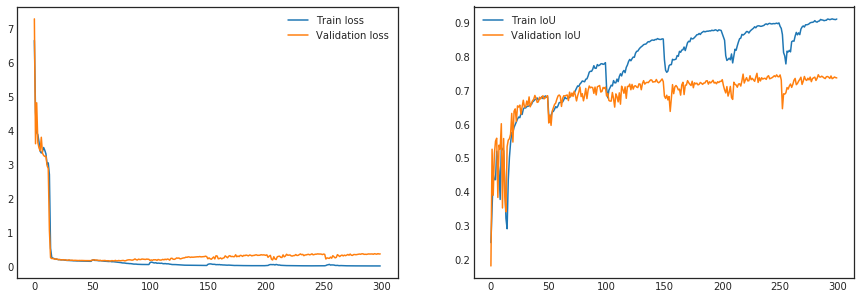

In [50]:
fig, (ax_loss, ax_iou) = plt.subplots(1, 2, figsize=(15,5))
ax_loss.plot(history['epoch'], history['train_loss'], label="Train loss")
ax_loss.plot(history['epoch'], history['val_loss'], label="Validation loss")
ax_loss.legend()
ax_iou.plot(history['epoch'], history['train_iou'], label="Train IoU")
ax_iou.plot(history['epoch'], history['val_iou'], label="Validation IoU")
ax_iou.legend()

In [51]:
filename = os.path.join(model_path(), 'model_best_state.pth')
checkpoint = torch.load(filename)
model.load_state_dict(checkpoint['state_dict'])
optimizer.load_state_dict(checkpoint['optimizer'])

In [52]:
def predict_tta(model, image): # predict both orginal and reflect x
    with torch.no_grad():
        image_reflect = np.flip(image.numpy(), axis=3).copy()
        with torch.cuda.device(0):
            image_gpu = image.type(torch.float).cuda()
            image_reflect_gpu = torch.as_tensor(image_reflect).type(torch.float).cuda()
        
        outputs = model(image_gpu)
        outputs_reflect = model(image_reflect_gpu)
        return (outputs.cpu().numpy() + np.flip(outputs_reflect.cpu().numpy(), axis=3))/2

In [53]:
model.eval()
predictions=[predict_tta(model, image) for image, _ in tqdm(val_data_loader)]

100%|██████████| 13/13 [00:04<00:00,  3.26it/s]


In [54]:
preds_valid = np.concatenate(predictions, axis=0).squeeze()

In [55]:
downsample_to = downsample(128, 101)

In [56]:
preds_valid=np.array(list(map(downsample_to, preds_valid)))

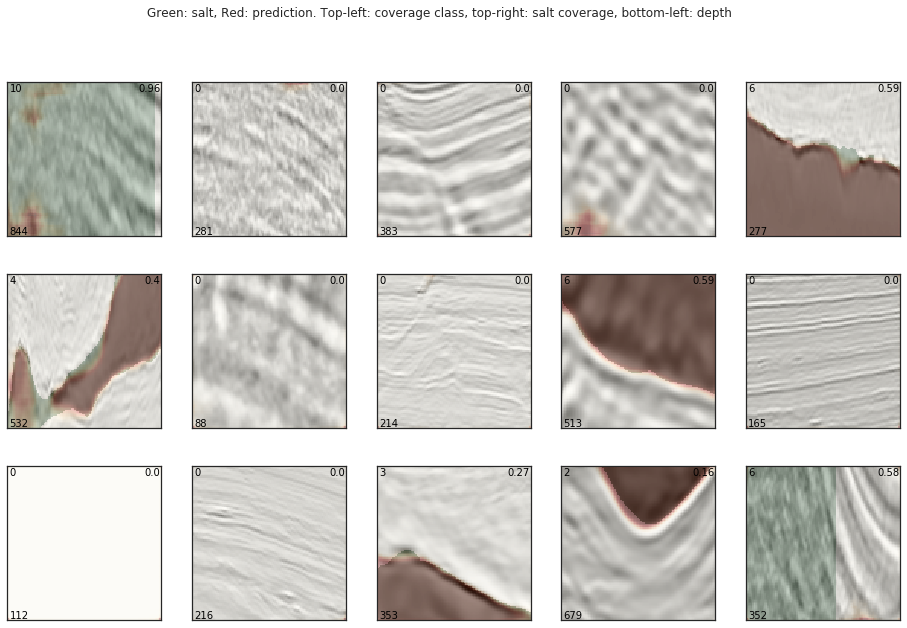

In [57]:
plot_predictions(train_df, preds_valid, ids_valid, max_images=15, grid_width=5, figsize=(16,10))

In [58]:
## Scoring for last model, choose threshold using validation data 
thresholds = np.linspace(0.3, 0.7, 31)
y_valid_down = np.array(list(map(downsample_to, y_valid.squeeze())))

ious = list(map(lambda th: iou_metric_batch(y_valid_down , np.int32(preds_valid > th)), 
                tqdm(thresholds)))

100%|██████████| 31/31 [00:34<00:00,  1.12s/it]


In [59]:
threshold_best_index = np.argmax(ious)
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]

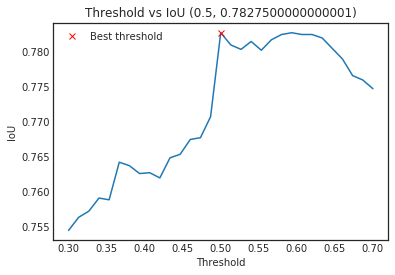

In [60]:
plt.plot(thresholds, ious)
plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
plt.legend()

In [61]:
preds_thresh_iter = map(lambda pred: np.array(np.round(pred > threshold_best), dtype=np.float32), preds_valid)
preds_thresh = np.array(list(map(downsample_to, preds_thresh_iter)))

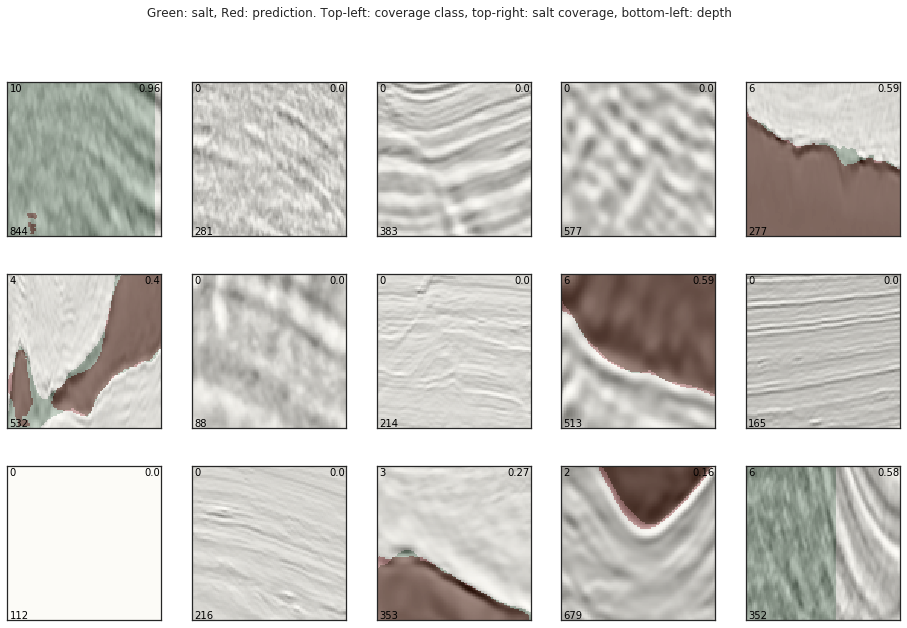

In [62]:
plot_predictions(train_df, preds_thresh, ids_valid, max_images=15, grid_width=5, figsize=(16,10))

In [63]:
x_test = load_images_as_arrays(test_df.index, test_images_path())
x_test = list(map(upsample_to, x_test))
x_test = np.array(x_test).reshape(-1, 1, img_size_target, img_size_target)

100%|██████████| 18000/18000 [00:14<00:00, 1275.71it/s]


In [64]:
dataset_test = TGSSaltDataset(x_test, is_test = True)

In [65]:
test_data_loader = data.DataLoader(dataset_test, 
                                   batch_size = batch_size,
                                   shuffle = False, 
                                   num_workers = num_workers,
                                   pin_memory=True,
                                   drop_last=False)

In [66]:
model.eval()
predictions=[predict_tta(model, image) for image in tqdm(test_data_loader)]

100%|██████████| 282/282 [01:29<00:00,  3.35it/s]


In [67]:
preds_test = np.concatenate(predictions, axis=0).squeeze()

In [68]:
transform = compose(rle_encode, 
                    np.round,
                    downsample_to,
                    lambda x: x > threshold_best)

In [69]:
pred_dict = {idx: transform(preds_test[i]) for i, idx in enumerate(tqdm(test_df.index.values))}

100%|██████████| 18000/18000 [00:20<00:00, 898.20it/s]


In [70]:
sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
filename=os.path.join(model_path(),f"submission_{now:%d%b%Y_%H}.csv")
sub.to_csv(filename)